# Computer Assignment 3
## Group 3

## Introduction
Consider the optimization problem below:
\begin{align}
    E=\min_{w_3, W_2,W_1} \frac{1}{N}\sum_i || w_3 s(W_2 s(W_1 x_i)-y_i)||^2.   
\end{align}

In this assignment we are comparing different the performance of various methods including GD, SGD and SVRG.
(Note that the implementation of perturbed GD and block coordingate descent is missing due to shortage of time and will be completed.)

The important block that was needed to implement the gradient descent is the back propagation. Since the optimization problem is performed with a multilayer neural network, the back propagation requires a deeper analysis.

## Back propagation
Below we are explaining the steps to obtain the updating step for each layer. We start from the last layer and propagate the update backwards.

### Layer 3
Define the outputs of each layer as:
\begin{align}
a_3(x)& :=w_3 s(W_2 s(W_1 x))\\
a_2(x)& :=s(W_2 s(W_1 x)),\\
a_1(x)& :=s(W_1 x).
\end{align}

Then
\begin{align}
\frac{\partial E}{\partial w_3} &= \frac{2}{N}(a_3-t)\frac{\partial a_3}{\partial w_3} \\
&=\frac{2}{N}(x_3-t)\frac{\partial w_3a_2}{\partial w_3}\\
&=\frac{2}{N}(x_3-t)a_2^T\\
\end{align}

So defining 
$$\delta_3 := \frac{2}{N}(a_3-t),$$
then
$$\frac{\partial E}{\partial w_3} =\delta_3\,a_2^T.$$

### Layer 2

\begin{align*}
\frac{\partial E}{\partial W_2} &= \frac{2}{N}(a_3-t)\frac{\partial a_3}{\partial W_2} \\
&=\frac{2}{N}(a_3-t)\frac{\partial (W_3 a_2)}{\partial W_2}\\
&=\delta_3\frac{\partial (W_3 a_2)}{\partial W_2}\\
&=W_3^T\delta_3\frac{\partial a_2}{\partial W_2}\\
&=[W_3^T\delta_3 \circ s'(W_2 a_1)]\frac{\partial W_2 a_1}{\partial W_2}\\
\end{align*}

So defining $$\delta_2 :=W_3^T\delta_3 \circ s'(W_2 a_1),$$
we have

$$\frac{\partial E}{\partial W_2}=\delta_2 a_1^T$$

### Layer 1

Define 
$$\delta_1 :=W_2^T\delta_2 \circ s'(W_1x),$$
similar to layer_2:
\begin{align*}
\frac{\partial E}{\partial W_1} &=\delta_1x^T
\end{align*}

In [ ]:
# Import libraries
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import itertools
import argparse
import sys
import time
from sklearn import preprocessing
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import random
from math import floor

In [ ]:
## Preprocessing of data
# Function to load data

def get_power_data():
    """
    Read the Individual household electric power consumption dataset
    """
    
    # Assume that the dataset is located on folder "data"
    data = pd.read_csv('data/household_power_consumption.txt',
                       sep=';', low_memory=False)

    # Drop some non-predictive variables
    data = data.drop(columns=['Date', 'Time'], axis=1)

    #print(data.head())

    # Replace missing values
    data = data.replace('?', np.nan)

    # Drop NA
    data = data.dropna(axis=0)

    # Normalize
    standard_scaler = preprocessing.StandardScaler()
    np_scaled = standard_scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)

    # Goal variable assumed to be the first
    X = data.values[:, 1:].astype('float32')
    y = data.values[:, 0].astype('float32')

    # Create categorical y for binary classification with balanced classes
    y = np.sign(y+0.46)

    # Split train and test data here: (X_train, Y_train, X_test, Y_test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    no_class = 2                 #binary classification

    return X_train.T, X_test.T, y_train, y_test, no_class

In [ ]:
X_train, X_test, y_train, y_test, no_class = get_power_data()
print("X,y types: {} {}".format(type(X_train), type(y_train)))
print("X size {}".format(X_train.shape))
print("Y size {}".format(y_train.shape))

# Create a binary variable from one of the columns.
# You can use this OR not

idx = y_train >= 0
notidx = y_train < 0
y_train[idx] = 1
y_train[notidx] = -1

In [ ]:
# Sigmoid function
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

# Define weights initialization
def initialize_w(N, d):
    return 2*np.random.random((N,d)) - 1

# Fill in feed forward propagation
def feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda):
    # Fill in
    #X is q x n
    # w_1 is p x q
    # w_2 is p x p
    # w_3 is 1 x p
    layer_0=X # q x n
    layer_1=sigmoid(np.matmul(w_1 , X)) # p x n 
    layer_2=sigmoid(np.matmul(w_2 , layer_1)) # p x n 
    layer_3=np.matmul(w_3 , layer_2) # p x n
    return layer_0, layer_1, layer_2, layer_3


# Fill in backpropagation    
def back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3):
    # Calculate the gradient here
    N = y.shape[0]    
        
    delta3=2/N*(layer_3 - y)
    delta2=np.multiply(np.matmul(w_3.T,delta3),sigmoid(np.matmul(w_2,layer_1),derivative=True))
    delta1=np.multiply(np.matmul(w_2.T,delta2),sigmoid(np.matmul(w_1,layer_0),derivative=True))
    
    layer_3_delta=np.matmul(delta3,layer_2.T)
    layer_2_delta=np.matmul(delta2,layer_1.T)
    layer_1_delta=np.matmul(delta1,layer_0.T)

    return layer_1_delta, layer_2_delta, layer_3_delta


# Cost function
def cost(X, y, w_1, w_2, w_3, lmbda):
    N, d = X.shape
    a1,a2,a3,a4 = feed_forward_propagation(X,y,w_1,w_2,w_3,lmbda)

    return np.linalg.norm(a4[:,0] - y,2) ** 2 / N

# Funtion to get mini batch sgd
def miniBatch(x,y,batchSize):
    D,N = x.shape
    X_mini = np.zeros((D,batchSize))
    Y_mini = np.zeros((batchSize,))
    indexArray = random.sample(range(N), batchSize)
    for i in range(batchSize):
        X_mini[:,i] = x[:,indexArray[i]]
        Y_mini[i,] = y[indexArray[i],]
    return X_mini,Y_mini

# Define SGD
def SGD(X, y, w_1, w_2, w_3, lmbda, learning_rate, batch_size, iterations):
    cost_l=[]
    for i in range(iterations):

        X_mini,Y_mini = miniBatch(X,y,batch_size)
        L0,L1,L2,L3 = feed_forward_propagation(X_mini,Y_mini,w_1,w_2,w_3,lmbda)
        D1,D2,D3 = back_propagation(Y_mini,w_1,w_2,w_3,L0,L1,L2,L3)

        #cost1 = cost(X_mini, Y_mini, w_1, w_2, w_3, lmbda)
        
        a = w_1-(learning_rate*D1).reshape(w_1.shape)
        b = w_2-(learning_rate*D2).reshape(w_2.shape)
        c = w_3-(learning_rate*D3).reshape(w_3.shape)
        
        #cost2 = cost(X_mini, Y_mini, a, b, c, lmbda)
    
        #if ((cost2-cost1)/cost1>0.5):
        #    break
        
        w_1 = a
        w_2 = b
        w_3 = c
                
        cost_l.append(cost(X,y,w_1,w_2,w_3,lmbda=lmbda))
        #print(i,': ', cost_l[-1])
    return w_1, w_2, w_3, cost_l

# Define SVRG here:
def SVRG(X, y, w_1, w_2, w_3, lmbda, learning_rate, T,M,iterations):
    #M is the numebr of samples used in the minibatch
    cost_l=[]    
    for i in range(iterations):
        
        K  = floor(iterations/T)
        N  = X.shape[1]
        wk_1= w_1
        wk_2= w_2
        wk_3= w_3
        
        for k in range(K):
            L0,L1,L2,L3 = feed_forward_propagation(X,y,w_1,w_2,w_3,lmbda)
            ga_1, ga_2, ga_3 = back_propagation(y,wk_1,wk_2,wk_3,L0,L1,L2,L3) #the average
            
            for t in range(T):
                index = np.random.randint(N, size=M)
                L0,L1,L2,L3 = feed_forward_propagation(X[:,index],y[index,],w_1,w_2,w_3,lmbda)
                g1_1,g1_2,g1_3 = back_propagation(y[index,], w_1,w_2,w_3,L0,L1,L2,L3)
                
                Lk0,Lk1,Lk2,Lk3 = feed_forward_propagation(X[:,index],y[index,],wk_1,wk_2,wk_3,lmbda)
                g2_1,g2_2,g2_3 = back_propagation(y[index,], wk_1,wk_2,wk_3,Lk0,Lk1,Lk2,Lk3)
                
                g1  = g1_1 - g2_1 + ga_1
                g2  = g1_2 - g2_2 + ga_2
                g3  = g1_3 - g2_3 + ga_3

                #cost1 = cost(X, y, w_1, w_2, w_3, lmbda)
            
                w_1 = w_1 - (learning_rate*g1).reshape(w_1.shape)
                w_2 = w_2 - (learning_rate*g2).reshape(w_2.shape)
                w_3 = w_3 - (learning_rate*g3).reshape(w_3.shape)
            

            wk_1 = w_1
            wk_2 = w_2
            wk_3 = w_3
        cost_l.append(cost(X,y,w_1,w_2,w_3,lmbda=lmbda))    
        #print(i,': ', cost_l[-1])        
    return w_1, w_2, w_3, cost_l

# Define GD here:
def GD(X, y, w_1,w_2,w_3, learning_rate, lmbda, iterations):
    cost_l=[]
    for i in range(iterations): 
        
        L0,L1,L2,L3 = feed_forward_propagation(X,y,w_1,w_2,w_3,lmbda)
        D1,D2,D3 = back_propagation(y,w_1,w_2,w_3,L0,L1,L2,L3)
    
        #cost1 = cost(X, y, w_1, w_2, w_3, lmbda)
        
        w_1 = w_1-(learning_rate*D1).reshape(w_1.shape)
        w_2 = w_2-(learning_rate*D2).reshape(w_2.shape)
        w_3 = w_3-(learning_rate*D3).reshape(w_3.shape)
        
        cost_l.append(cost(X,y,w_1,w_2,w_3,lmbda=lmbda))
        #print(i,': ', cost_l[-1])        
    
    return w_1, w_2, w_3, cost_l

# Define projected GD here:
def PGD(X, y, w_1,w_2,w_3, learning_rate, lmbda, iterations, noise):
    # Complete here:
    
    return w_1, w_2, w_3

# Define BCD here:
def BCD(X, y, w_1,w_2,w_3, learning_rate, lmbda, iterations):
    # Complete here:
    
    return w_1, w_2, w_3







In [ ]:
# Tuning hyper parameters:
GD_params=[]
GD_cost=[]

SGD_params=[]
SGD_cost=[]

SVRG_params=[]
SVRG_cost=[]

for W_SIZE in [3,5,10]:
    while(True):
        w_1 = initialize_w(W_SIZE,X_train.shape[0])
        w_2 = initialize_w(W_SIZE,W_SIZE)
        w_3 = initialize_w(1,W_SIZE)    
        initialCost = cost(X_train,y_train,w_1,w_2,w_3,lmbda=0.1)
        if(initialCost>300000):
            print("init:",initialCost)
            break
    
    
    for LAMBDA in [0.01,0.05,0.1]:
        for LR in [0.01,0.05,0.1]:
            
            #GD
            GD_params.append([W_SIZE,LAMBDA,LR])
            w_1_GD,w_2_GD,w_3_GD,cost_l_GD = GD(X_train, y_train, w_1,w_2,w_3, learning_rate = LR, lmbda=LAMBDA, iterations=50)
            GD_cost.append(cost_l_GD)
            print("GD:",GD_cost[-1][-1])
           
            #SGD
            for B_SIZE in [2,10,100]:
                SGD_params.append([W_SIZE,LAMBDA,LR,B_SIZE])
                w_1_SGD,w_2_SGD,w_3_SGD,cost_l_SGD = SGD(X_train, y_train, w_1,w_2,w_3, learning_rate = LR, lmbda=LAMBDA,batch_size=B_SIZE, iterations=50)
                SGD_cost.append(cost_l_SGD)
                print("SGD:",SGD_cost[-1][-1])   

            #SVRG
            for T_ in [2,5,10]:
                for M_ in [2,10,100]:
                    SVRG_params.append([W_SIZE,LAMBDA,LR,T_,M_])
                    w_1_SVRG,w_2_SVRG,w_3_SVRG,cost_l_SVRG = SVRG(X_train, y_train, w_1,w_2,w_3, learning_rate = LR, lmbda=LAMBDA,T=T_,M=M_, iterations=10)
                    SVRG_cost.append(cost_l_SVRG)
                    print("SVRG:",SVRG_cost[-1][-1])                   
                
            
            
        
        

In [ ]:
import pickle as pk

# open a file, where you ant to store the data
file = open('Hyper', 'wb')
# dump information to that file
pk.dump((GD_cost,GD_params,SGD_cost,SGD_params,SVRG_cost,SVRG_params), file)

file.close()

## Tuning hyper parameters

Below we plot the performance of each solver for different choices of hyper parameters. The best obtained parameters for each method is stated in tabel below:



| solver   | W_Dim         | lambda        | LR       |Batch size |T        |M         | Cost     |
|----      | ------------- |:-------------:| --------:|--------:  |--------:|--------: |--------: |
|GD        | 3             | 0.01          |0.05      |     -     | -       |-         |**256174**|
|SGD       | 3             | 0.01          |0.05      |     2     | -       |-         |**256159**|
|SVRG      | 3             | 0.01          |0.05      |     -     | 10      |2         |**256334**|




No handles with labels found to put in legend.
No handles with labels found to put in legend.


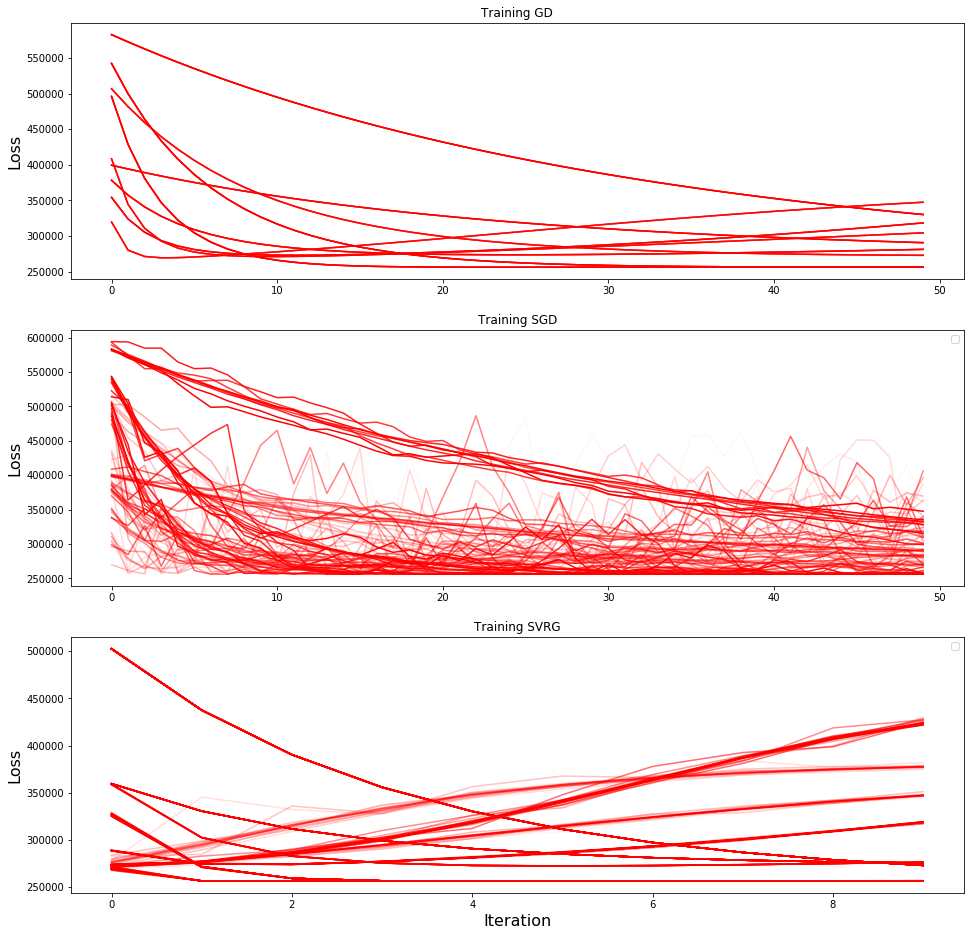

In [51]:
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt


file = open('Hyper', 'rb')
GD_cost,GD_params,SGD_cost,SGD_params,SVRG_cost,SVRG_params=pk.load(file)
file.close()


# Plot results
fig, ax = plt.subplots(3, 1, figsize=(16, 16))
#ax[0].set_xlabel(r"Iteration", fontsize=16)
ax[0].set_ylabel("Loss", fontsize=16)
ax[0].set_title("Training GD")
#ax[0].set_ylim(ymin=0)

ax[1].legend(loc="upper right")
#ax[1].set_xlabel(r"Iteration", fontsize=16)
ax[1].set_ylabel("Loss", fontsize=16)
ax[1].set_title("Training SGD")
#ax[0].set_ylim(ymin=0)

ax[2].legend(loc="upper right")
ax[2].set_xlabel(r"Iteration", fontsize=16)
ax[2].set_ylabel("Loss", fontsize=16)
ax[2].set_title("Training SVRG")
#ax[0].set_ylim(ymin=0)


for i in range(len(GD_cost)):
    alpha=(len(SGD_cost)-i)/len(SGD_cost)
        
    ax[0].plot(GD_cost[i],color=(1,0,0,alpha),label='W_d='+str(GD_params[i][0])+', lmba='+str(GD_params[i][1])+', Lr='+str(GD_params[i][2]))
    #ax[0].legend(loc="upper right")

for i in range(len(SGD_cost)):
    alpha=(len(SGD_cost)-i)/len(SGD_cost)
    ax[1].plot(SGD_cost[i],color=(1,0,0,alpha),label='W_d='+str(SGD_params[i][0])+', lmba='+str(SGD_params[i][1])+', Lr='+str(SGD_params[i][2])+', B_size='+str(SGD_params[i][3]))
    #ax[1].legend(loc="upper right")

for i in range(len(SVRG_cost)):
    alpha=(len(SVRG_cost)-i)/len(SVRG_cost)   
    ax[2].plot(SVRG_cost[i],color=(1,0,0,alpha),label='W_d='+str(SVRG_params[i][0])+', lmba='+str(SVRG_params[i][1])+', Lr='+str(SVRG_params[i][2])+', T_loop='+str(SVRG_params[i][3])+', ineer_batch='+str(SVRG_params[i][4]))
    #ax[2].legend(loc="upper right")

GD parameters [3, 0.01, 0.05] 256174.73857817857
SGD parameters [3, 0.01, 0.05, 2] 256159.92059735706
SVRG parameters [3, 0.01, 0.05, 10, 2] 256334.92999192805


Text(0.5, 1.0, 'Best trained')

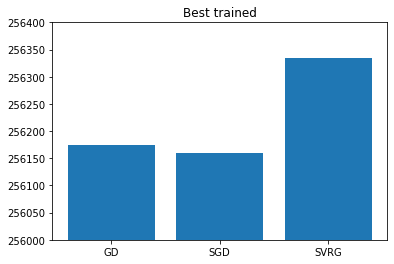

In [87]:
x=np.arange(3)

GD_besti=np.argmin([item[-1] for item in GD_cost])
SGD_besti=np.argmin([item[-1] for item in SGD_cost])
SVRG_besti=np.argmin([item[-1] for item in SVRG_cost])

print("GD parameters",GD_params[GD_besti],GD_cost[GD_besti][-1])
print("SGD parameters",SGD_params[SGD_besti],SGD_cost[SGD_besti][-1])
print("SVRG parameters",SVRG_params[SVRG_besti],SVRG_cost[SVRG_besti][-1])

x=np.arange(3)
plt.bar(x,[GD_cost[GD_besti][-1],SGD_cost[SGD_besti][-1],SVRG_cost[SVRG_besti][-1]])
plt.xticks(x, ('GD', 'SGD', 'SVRG'))
plt.ylim(ymin=256000,ymax=256400)
plt.title('Best trained')

([<matplotlib.axis.XTick at 0x24e6f538eb8>,
 <a list of 3 Text xticklabel objects>)

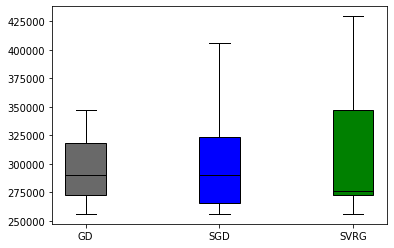

In [85]:
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
def setBoxColors(bp,color,fill_color):
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=color)        
        
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

labels=['GD','SGD','SVRG']
bp=plt.boxplot([item[-1] for item in GD_cost],positions=[1],widths=0.6, patch_artist=True)
setBoxColors(bp,'black','dimgray')
bp=plt.boxplot([item[-1] for item in SGD_cost],positions=[3],widths=0.6, patch_artist=True)
setBoxColors(bp,'black','blue')
bp=plt.boxplot([item[-1] for item in SVRG_cost],positions=[5],widths=0.6, patch_artist=True)
setBoxColors(bp,'black','green')

plt.xticks([1, 3, 5], labels)